Repo: https://github.com/aditya-grover/node2vec/tree/master

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors, Word2Vec

In [ ]:
class Graph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        """
        Simulate a random walk starting from start node.
        """
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[
                            alias_draw(
                                alias_nodes[cur][0],
                                alias_nodes[cur][1]
                            )
                        ]
                    )
                else:
                    prev = walk[-2]
                    next_node = cur_nbrs[
                        alias_draw(
                            alias_edges[(prev, cur)][0],
                            alias_edges[(prev, cur)][1]
                        )
                    ]
                    walk.append(next_node)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        """
        Repeatedly simulate random walks from each node.
        """
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print('Walk iteration:')
        for walk_iter in range(num_walks):
            print(f'{walk_iter + 1} / {num_walks}')
            random.shuffle(nodes)
            for node in nodes:
                walks.append(
                    self.node2vec_walk(
                        walk_length=walk_length,
                        start_node=node
                    )
                )
        return walks

    def get_alias_edge(self, src, dst):
        """
        Get the alias edge setup lists for a given edge.
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            weight = G[dst][dst_nbr].get('weight', 1.0)

            if dst_nbr == src:
                unnormalized_probs.append(weight / p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(weight)
            else:
                unnormalized_probs.append(weight / q)

        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob) / norm_const for u_prob in unnormalized_probs
        ]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [
                G[node][nbr].get('weight', 1.0)
                for nbr in sorted(G.neighbors(node))
            ]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob) / norm_const for u_prob in unnormalized_probs
            ]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges


def alias_setup(probs):
    """
    Compute utility lists for non-uniform sampling from discrete distributions.
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while smaller and larger:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


def alias_draw(J, q):
    """
    Draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)
    kk = int(np.floor(np.random.rand() * K))

    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


In [29]:
def learn_embeddings(
    walks,
    vector_size: int = 128,
    window: int = 10,
    workers: int = 8,
    epochs: int = 1
):
    """
    Learn embeddings by optimizing the Skip-gram objective using SGD.
    """

    # gensim requires lists, not iterators
    walks = [list(map(str, walk)) for walk in walks]

    model = Word2Vec(
        sentences=walks,
        vector_size=vector_size,
        window=window,
        min_count=0,
        sg=1,              # skip-gram
        workers=workers,
        epochs=epochs
    )

    # save in word2vec format (node2vec-compatible)
    model.wv.save_word2vec_format("embeddings.emb")

    return model

In [51]:
import networkx as nx

nx_G = nx.karate_club_graph()
G = Graph(nx_G, is_directed=False, p=0.8, q=0.1)

G.preprocess_transition_probs()
walks = G.simulate_walks(num_walks=20, walk_length=10)


Walk iteration:
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


In [52]:
walks[1]

[7, 0, 8, 33, 29, 26, 29, 32, 31, 25]

In [53]:
walks[-1]

[21, 1, 2, 28, 31, 25, 23, 33, 30, 1]

In [54]:
model = learn_embeddings(walks,epochs=100)

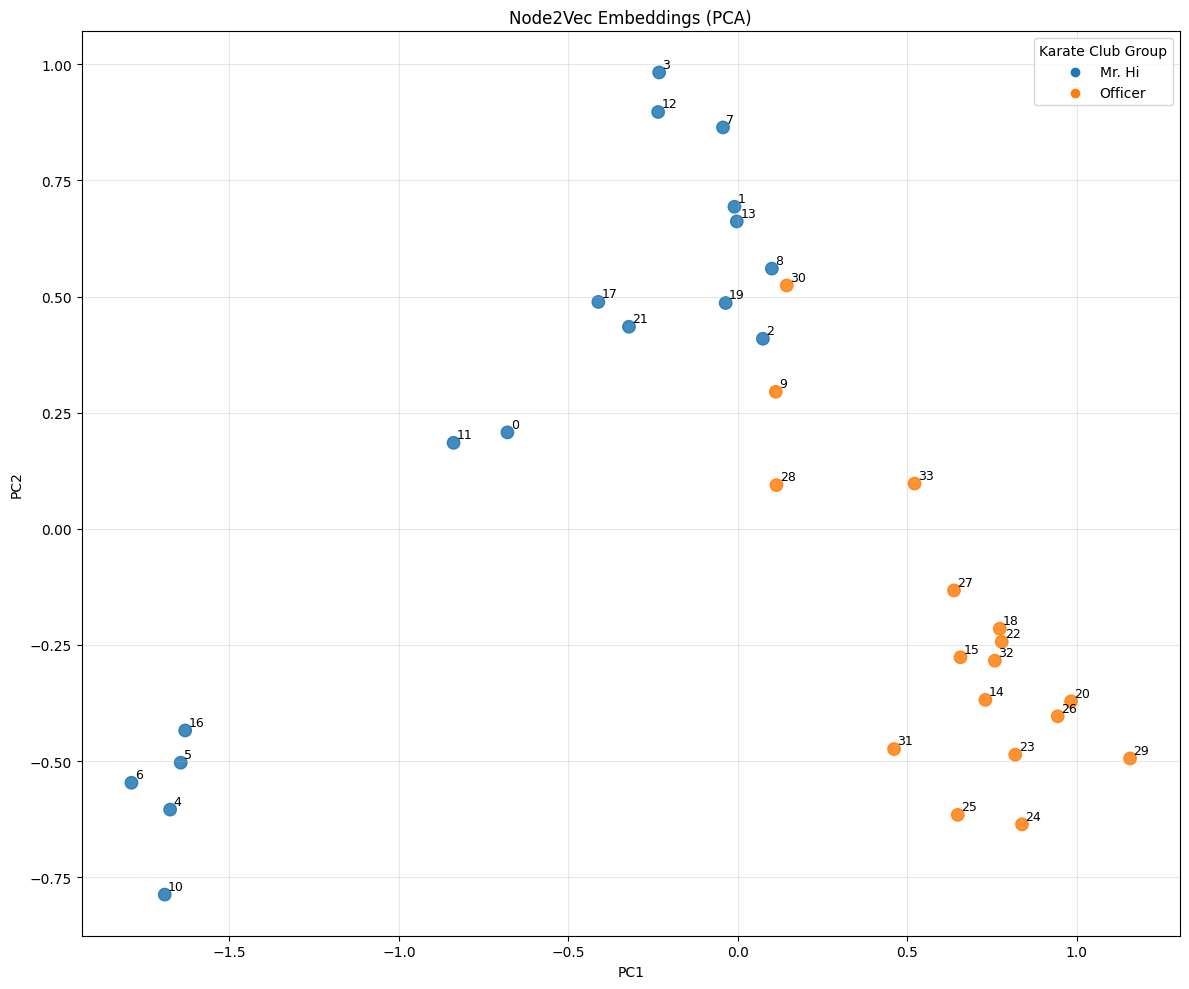

In [55]:
def load_embeddings(path="embeddings.emb"):
    kv = KeyedVectors.load_word2vec_format(path)
    nodes = kv.index_to_key
    X = np.array([kv[node] for node in nodes])
    return nodes, X


def plot_embeddings_pca(nodes, X, graph):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    club_to_color = {
        "Mr. Hi": "tab:blue",
        "Officer": "tab:orange"
    }

    colors = [
        club_to_color[graph.nodes[int(node)]["club"]]
        for node in nodes
    ]

    plt.figure(figsize=(12, 10))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=80, alpha=0.85)

    for i, node in enumerate(nodes):
        plt.text(
            X_2d[i, 0] + 0.01,
            X_2d[i, 1] + 0.01,
            node,
            fontsize=9
        )

    for club, color in club_to_color.items():
        plt.scatter([], [], c=color, label=club)

    plt.legend(title="Karate Club Group")
    plt.title("Node2Vec Embeddings (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# usage
G = nx.karate_club_graph()
nodes, X = load_embeddings("embeddings.emb")
plot_embeddings_pca(nodes, X, G)


{0: Text(-0.16376101554700706, 0.3296454210500073, '0'),
 1: Text(-0.22110656534937553, 0.15465314630123334, '1'),
 2: Text(-0.09674034038745226, -0.003757356042615751, '2'),
 3: Text(-0.3591582160224257, 0.17280320194223153, '3'),
 4: Text(-0.07229970663326067, 0.6118299837817424, '4'),
 5: Text(-0.09717721703874717, 0.7519323966688611, '5'),
 6: Text(-0.19477842436346776, 0.7423079030139283, '6'),
 7: Text(-0.32517252355509213, 0.07429495244628262, '7'),
 8: Text(-0.0011697920816430383, -0.10817287779231531, '8'),
 9: Text(0.004290475635961756, -0.5530221298634715, '9'),
 10: Text(0.042837332550225, 0.6887719750278708, '10'),
 11: Text(-0.4704485350940613, 0.5798729527921695, '11'),
 12: Text(-0.6315773708687186, 0.24946302293752232, '12'),
 13: Text(-0.15233910153280086, 0.04114092778664134, '13'),
 14: Text(0.30552515044162637, -0.5971952388226341, '14'),
 15: Text(-0.02829890942287378, -0.47329658577351874, '15'),
 16: Text(-0.14049188351450498, 1.0, '16'),
 17: Text(-0.3489855886

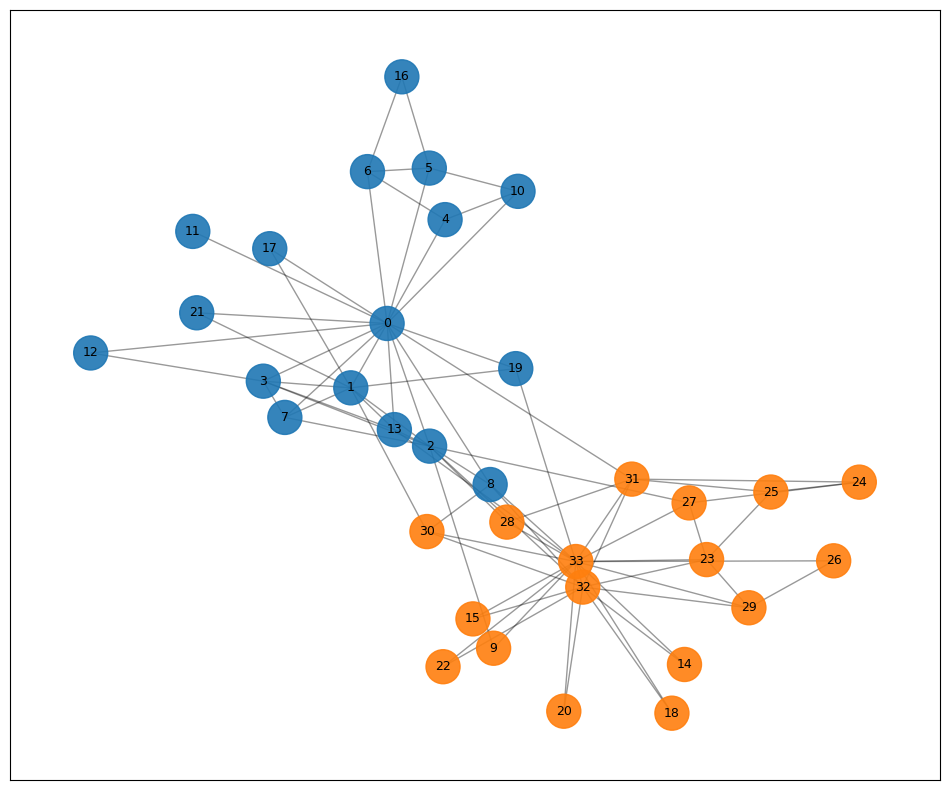

In [43]:
import networkx as nx
import matplotlib.pyplot as plt


# graph
G = nx.karate_club_graph()

# color by club
club_to_color = {
    "Mr. Hi": "tab:blue",
    "Officer": "tab:orange"
}

node_colors = [
    club_to_color[G.nodes[n]["club"]]
    for n in G.nodes()
]

# layout
pos = nx.spring_layout(G, seed=42)

# plot
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=600,
    alpha=0.9
)
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=9)

#
